## Add dataset "GPTSniffer" as input first

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
import pandas as pd
import numpy as np
#from timm.optim.lion import Lion
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [2]:
import random

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If using GPU, set the seed for the CUDA operations as well
torch.cuda.manual_seed_all(seed)

In [3]:
def get_code_without_comments(filepath):
    with open(filepath, 'rb') as f:
        lines = f.readlines()
    code_lines = []
    for line in tokenize.tokenize(lines.__iter__().__next__):
        if line.type != tokenize.COMMENT:
            code_lines.append(line.string)
    return ''.join(code_lines)

In [4]:
import re

def remove_java_comments(filepath):
    with open(filepath, 'r') as f:
        code = f.read()  # Read the entire file content

    # Remove single-line comments (//)
    code = re.sub(r'//.*', '', code)

    # Remove multi-line comments (/* ... */)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)

    return code


In [5]:
import re

def remove_python_comments(filepath):
    """
    Removes all Python comments (single-line and multi-line) from a file.

    Args:
        filepath (str): Path to the Python file.

    Returns:
        str: Code with comments removed.
    """
    with open(filepath, 'r') as f:
        code = f.read()  # Read the entire file content

    # Remove single-line comments (#)
    code = re.sub(r'#.*', '', code)

    # Remove multi-line comments (""" ... """ or ''' ... ''')
    code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    code = re.sub(r"'''.*?'''", '', code, flags=re.DOTALL)

    return code

In [6]:
# define the dataset
class CodeDataset(Dataset):
    def __init__(self, directory):
        self.samples = []
        for filename in os.listdir(directory):
            label = int(filename.split('_')[0])
            code = remove_python_comments(os.path.join(directory, filename))
            self.samples.append((code, label))
            # with open(os.path.join(directory, filename), 'r') as f:
            #     code = f.read()
            #     self.samples.append((code, label))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        code, label = self.samples[index]
        inputs = tokenizer.encode_plus(code, padding='max_length', max_length=512, truncation=True)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long), 
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long), 
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
#from google.colab import drive
#drive.mount('/content/drive/',force_remount=False)
#DATA_PATH = '/content/drive/My Drive/Colab Notebooks/SourceSniffer/'
DATA_PATH = '/kaggle/input/codechef/codechef/'
from os.path import join


# Set the directory where the training and testing data is stored
train_data_path = join(DATA_PATH,'training_data')
test_data_path = join(DATA_PATH,'testing_data') 


# Define the training dataset and dataloader
train_dataset = CodeDataset(train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define the testing dataset and dataloader
test_dataset = CodeDataset(test_data_path)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [8]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: Tensor of shape [batch_size, feature_dim]
        labels: Tensor of shape [batch_size]
        """
        batch_size = features.size(0)
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()  # Binary label mask
        features_normalized = features / features.norm(dim=1, keepdim=True)  # Normalize features
        
        logits = torch.div(
            torch.mm(features_normalized, features_normalized.T),
            self.temperature
        )  # Pairwise similarity logits
        logits_max = torch.max(logits, dim=1, keepdim=True).values
        logits -= logits_max.detach()  # Numerical stability

        exp_logits = torch.exp(logits) * mask  # Mask for same-class samples
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)

        # Compute mean log-probability for positive pairs
        mask_sum = mask.sum(dim=1)
        mean_log_prob_pos = (log_prob * mask).sum(dim=1) / (mask_sum + 1e-12)  # Avoid division by zero
        loss = -mean_log_prob_pos.mean()  # Average loss
        return loss


In [9]:
# Model with Binary Classifier
class CodeBERTBinaryClassifier(nn.Module):
    def __init__(self, encoder_model, hidden_size=256, num_layers=2):
        super(CodeBERTBinaryClassifier, self).__init__()
        self.encoder = encoder_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Dropout with 30%
            nn.Linear(self.encoder.config.hidden_size, 128),  # Hidden layer with 128 units
            nn.BatchNorm1d(128),  # Batch normalization for the hidden layer
            nn.ReLU(),  # ReLU activation for the hidden layer
            nn.Dropout(0.3),  # Dropout with 30%
            nn.Linear(128, 1)  # Output layer with 1 unit
        )
        
        

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token representation
        logits = self.classifier(cls_output.detach()).squeeze(-1)  # Squeeze for binary logit
        return logits, cls_output

In [10]:
# Define the tokenizer and the model
# tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
# base_model = AutoModel.from_pretrained("microsoft/codebert-base")

tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
base_model = AutoModel.from_pretrained("microsoft/graphcodebert-base")

model = CodeBERTBinaryClassifier(base_model)
model = model.to(device)

# optimizer = optim.AdamW(model.parameters(), lr=2e-5)
optimizer = optim.AdamW(
    [
        {"params": model.encoder.parameters(), "lr": 1e-6},  # Pre-trained layers
        {"params": model.classifier.parameters(), "lr": 1e-4},     # Task-specific head
    ],
    weight_decay=1e-2,
)
criterion = SupConLoss(temperature=0.07)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from tqdm import tqdm
import torch.nn.functional as F
# Define BCEWithLogitsLoss
classification_loss_fn = torch.nn.BCEWithLogitsLoss()
# Training Loop
alpha, beta = 2.0, 1.0  # Loss scaling factors
epochs = 35

alpha = 0.75  # Weight for positive class
gamma = 2.0   # Focusing parameter

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits, features = model(input_ids, attention_mask)

        features = F.normalize(features, p=2, dim=1)
        supcon_loss  = criterion(features, labels.float())
        # BCE loss on logits
        bce_loss = nn.BCEWithLogitsLoss()(logits.squeeze(-1), labels.float())
        # Combine the two losses
        total_loss = supcon_loss + bce_loss
        # total_loss = alpha * supcon_loss + beta * bce_loss
        
        # Backpropagation and optimizer step
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss/len(train_dataloader):.4f}")

    # if epoch > 40:
    #     torch.save(model.state_dict(), f'gpt_classifier_{epoch}.pth')

Epoch 1/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 1/35 Loss: 3.2505


Epoch 2/35: 100%|██████████| 80/80 [01:10<00:00,  1.14it/s]


Epoch 2/35 Loss: 2.8553


Epoch 3/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 3/35 Loss: 2.7592


Epoch 4/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 4/35 Loss: 2.7084


Epoch 5/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 5/35 Loss: 2.6863


Epoch 6/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 6/35 Loss: 2.6725


Epoch 7/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 7/35 Loss: 2.6625


Epoch 8/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 8/35 Loss: 2.6451


Epoch 9/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 9/35 Loss: 2.6423


Epoch 10/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 10/35 Loss: 2.6489


Epoch 11/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 11/35 Loss: 2.6301


Epoch 12/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 12/35 Loss: 2.6404


Epoch 13/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 13/35 Loss: 2.6357


Epoch 14/35: 100%|██████████| 80/80 [01:10<00:00,  1.14it/s]


Epoch 14/35 Loss: 2.6193


Epoch 15/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 15/35 Loss: 2.6327


Epoch 16/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 16/35 Loss: 2.6190


Epoch 17/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 17/35 Loss: 2.6181


Epoch 18/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 18/35 Loss: 2.6400


Epoch 19/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 19/35 Loss: 2.6124


Epoch 20/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 20/35 Loss: 2.6456


Epoch 21/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 21/35 Loss: 2.6252


Epoch 22/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 22/35 Loss: 2.6308


Epoch 23/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 23/35 Loss: 2.6459


Epoch 24/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 24/35 Loss: 2.6294


Epoch 25/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 25/35 Loss: 2.6276


Epoch 26/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 26/35 Loss: 2.6357


Epoch 27/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 27/35 Loss: 2.6438


Epoch 28/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 28/35 Loss: 2.6607


Epoch 29/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 29/35 Loss: 2.6294


Epoch 30/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 30/35 Loss: 2.6288


Epoch 31/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 31/35 Loss: 2.6353


Epoch 32/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 32/35 Loss: 2.6390


Epoch 33/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 33/35 Loss: 2.6546


Epoch 34/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]


Epoch 34/35 Loss: 2.6311


Epoch 35/35: 100%|██████████| 80/80 [01:10<00:00,  1.13it/s]

Epoch 35/35 Loss: 2.6401


In [12]:
torch.save(model.state_dict(), "codebert_binary_classifier.pth")

In [13]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def infer_test_dataset(model, test_dataset, batch_size=8, device="cuda"):
    model.eval()  # Set the model to evaluation mode
    dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    predictions = []
    logits_list = []

    with torch.no_grad():  # Disable gradient computation for inference
        for batch in tqdm(dataloader, desc="Inferencing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through the model
            logits, _ = model(input_ids, attention_mask)
            logits = logits.cpu()  # Move logits back to CPU for processing
            probabilities = torch.sigmoid(logits)
            preds = (probabilities > 0.5).long()  # Threshold at 0.5 for binary labels

            predictions.extend(preds.tolist())
            logits_list.extend(probabilities.tolist())

    return predictions, logits_list

In [14]:
# checkpoint = torch.load("/kaggle/working/gpt_classifier_82.pth")
# model.load_state_dict(checkpoint)


# Ground truth labels (from your test dataset)
true_labels = [sample['labels'].item() for sample in test_dataset]

predictions, logits = infer_test_dataset(model, test_dataset, batch_size=8, device=device)

# Analyze predictions
# for i, (pred, logit, true) in enumerate(zip(predictions, logits, true_labels)):
#     print(f"Sample {i}: Predicted Label = {pred}, Logit = {logit}, True Label = {true}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Inferencing: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s]

Accuracy: 0.9245
Precision: 0.9592
Recall: 0.8868
F1 Score: 0.9216
Confusion Matrix:
[[153   6]
 [ 18 141]]


In [15]:
from sklearn.manifold import TSNE# Parameters
import seaborn as sns

def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Inferencing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["labels"].to(device)
            logits, features = model(input_ids, attention_mask)
            embeddings.append(features.cpu().numpy())
            labels.extend(label.cpu().numpy())
    return np.concatenate(embeddings), np.array(labels)

Inferencing: 100%|██████████| 80/80 [00:20<00:00,  3.94it/s]


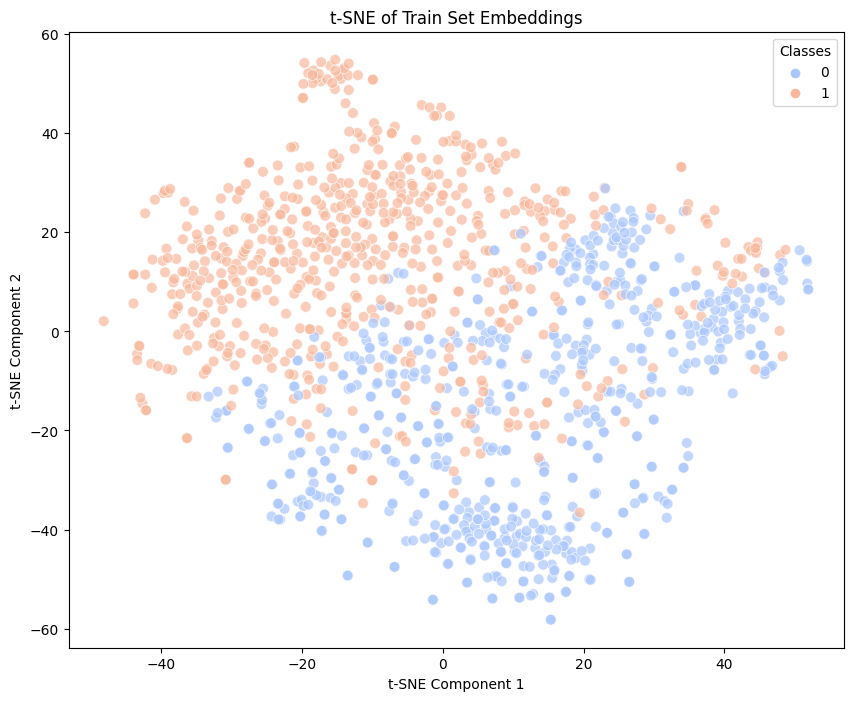

In [16]:
embeddings, labels = get_embeddings(model, train_dataloader, device)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot t-SNE of learned embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="coolwarm", s=60, alpha=0.7)
plt.title("t-SNE of Train Set Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")
plt.show()


Inferencing: 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


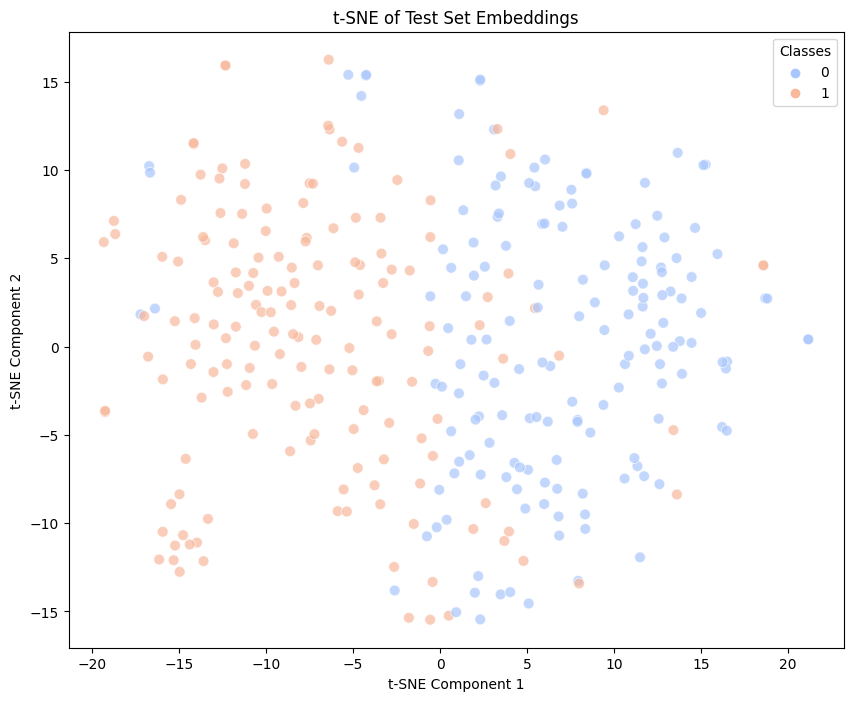

In [17]:
embeddings, labels = get_embeddings(model, test_dataloader, device)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot t-SNE of learned embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette="coolwarm", s=60, alpha=0.7)
plt.title("t-SNE of Test Set Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")
plt.show()